
--- Dataset Summary ---
Total Classes Found: 7
Total Images Found: 28709

Class-wise Image Counts:
- **angry**: 3995 images
- **disgust**: 436 images
- **fear**: 4097 images
- **happy**: 7215 images
- **neutral**: 4965 images
- **sad**: 4830 images
- **surprise**: 3171 images

Data Imbalance Ratio (Max/Min): 16.55


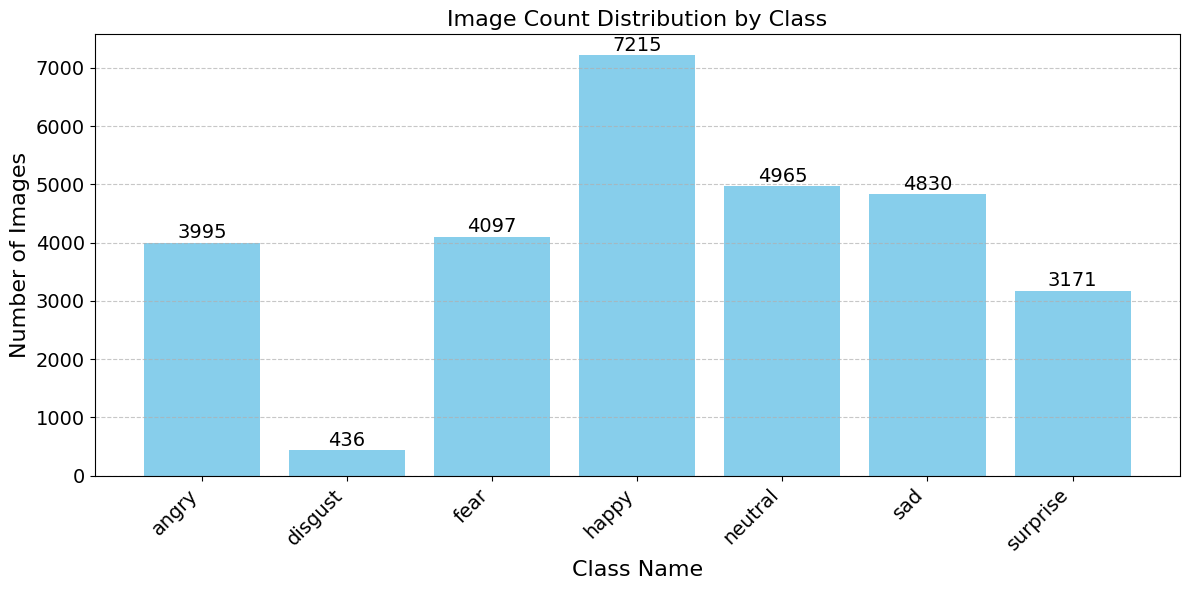


Plot displayed.


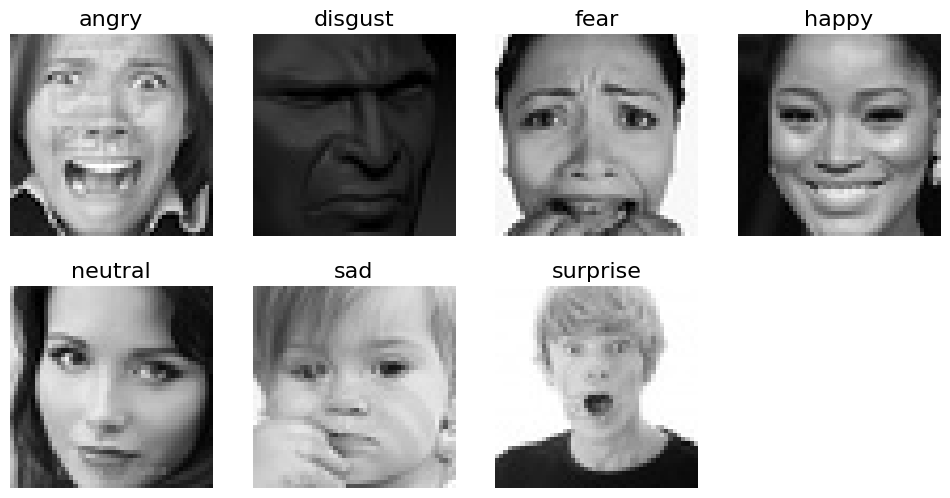

In [1]:
import os
from src import ImageDatasetExplorer

TRAIN_DATASET_ROOT = os.path.join("..", "archive", "train")
TEST_DATASET_ROOT = os.path.join("..", "archive", "test")
explorer = ImageDatasetExplorer(TRAIN_DATASET_ROOT)
explorer.explore_data()
explorer.plot_class_distribution()
explorer.display_some_random_samples()

tensor([0.5038]) tensor([0.2550])


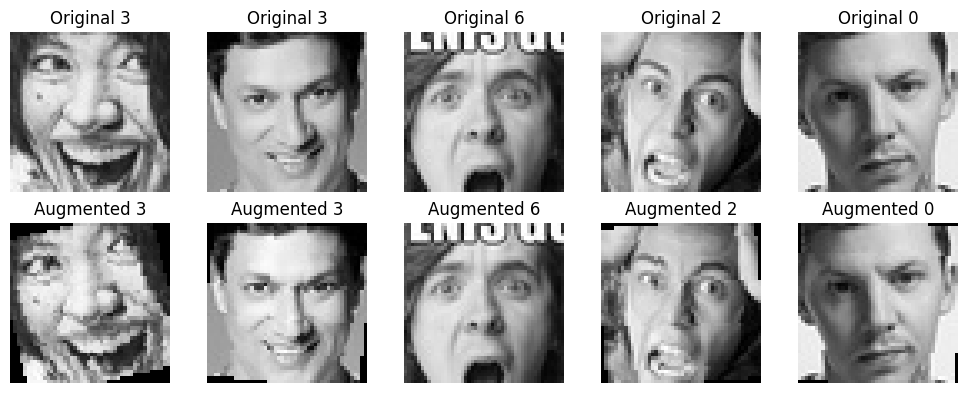

In [2]:
from src import DataPreprocessing

process = DataPreprocessing(TRAIN_DATASET_ROOT)
mean,std = process.calculate_mean_and_std()
print(mean,std)
train_transformation = process.augment_and_transform_data()

In [ ]:
import torch
import torch.nn as nn
import json
import torch.optim as optim
from src import MLP_network, Training, Evaluate, DataPreprocessing
from torchvision.transforms import v2
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

# process = DataPreprocessing(TRAIN_DATASET_ROOT)
list_of_transform_pipeline=[ v2.ToImage(),v2.Grayscale(num_output_channels=1),v2.ToDtype(torch.float32, scale=True), v2.Normalize(mean=mean,std=std)]
train_transformation = process.augment_and_transform_data(plot_original_vs_augmented=0)
test_transformation = process.augment_and_transform_data(list_of_transform_pipeline=list_of_transform_pipeline,plot_original_vs_augmented=0)
train_dataset=ImageFolder(TRAIN_DATASET_ROOT,transform=train_transformation)
train_loader=DataLoader(train_dataset,batch_size=512,shuffle=True)

test_dataset=ImageFolder(TEST_DATASET_ROOT,transform=test_transformation)
test_loader=DataLoader(test_dataset,batch_size=512,shuffle=False)

device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")


model_mlp=MLP_network().to(device)
SAVE_DIR = "../content/saved_model"
os.makedirs(SAVE_DIR, exist_ok=True)
SAVE_PATH = os.path.join(SAVE_DIR, "best_mlp.pth")
optimizer=optimizer=optim.Adam(model_mlp.parameters(),lr=1e-03)
loss_func=nn.CrossEntropyLoss()

trainer=Training(model=model_mlp,optimizer=optimizer,loss_func=loss_func,device=device,save_path=SAVE_PATH)
history_mlp=trainer.train_model(train_loader,test_loader,300)

with open(os.path.join(SAVE_DIR, "history_mlp.json"), 'w') as f:
    json.dump(history_mlp, f)

Using cpu device
---Training----
Epoch 1 --- train_loss 1.7945025627165196, train_acc 0.2682434079905256 --- test_loss 1.702060375548432, test_acc 0.3166620228475899
---Training----
Epoch 2 --- train_loss 1.7299178327453262, train_acc 0.3058971054373193 --- test_loss 1.6765685348199848, test_acc 0.3496795764837002
---Training----
Epoch 3 --- train_loss 1.7024551093497369, train_acc 0.3250200285624717 --- test_loss 1.6587932685119722, test_acc 0.3594315965449986
---Training----
Epoch 4 --- train_loss 1.688241404447981, train_acc 0.32913023790448986 --- test_loss 1.6407855121695454, test_acc 0.36723321259403735
---Training----
Epoch 5 --- train_loss 1.6825719294185453, train_acc 0.3325089693127591 --- test_loss 1.6295082759113158, test_acc 0.3598495402619114
---Training----
Epoch 6 --- train_loss 1.6701489672474306, train_acc 0.33780347626179946 --- test_loss 1.6173595689272409, test_acc 0.37280579548620785
---Training----
Epoch 7 --- train_loss 1.6561184134236357, train_acc 0.3476610122

Using cuda device

Classification report
              precision    recall  f1-score   support

       Angry     0.4341    0.1649    0.2390       958
     Disgust     1.0000    0.1351    0.2381       111
        Fear     0.3580    0.1416    0.2029      1024
       Happy     0.4591    0.8078    0.5855      1774
     Neutral     0.4686    0.3082    0.3718      1233
         Sad     0.3028    0.4771    0.3705      1247
    Surprise     0.7465    0.4465    0.5587       831

    accuracy                         0.4315      7178
   macro avg     0.5384    0.3545    0.3667      7178
weighted avg     0.4575    0.4315    0.4022      7178


Evaluation Metrics (Weighted Average):
Accuracy:   0.4315
Precision:  0.4575
Recall:     0.4315
F1-Score:   0.4022



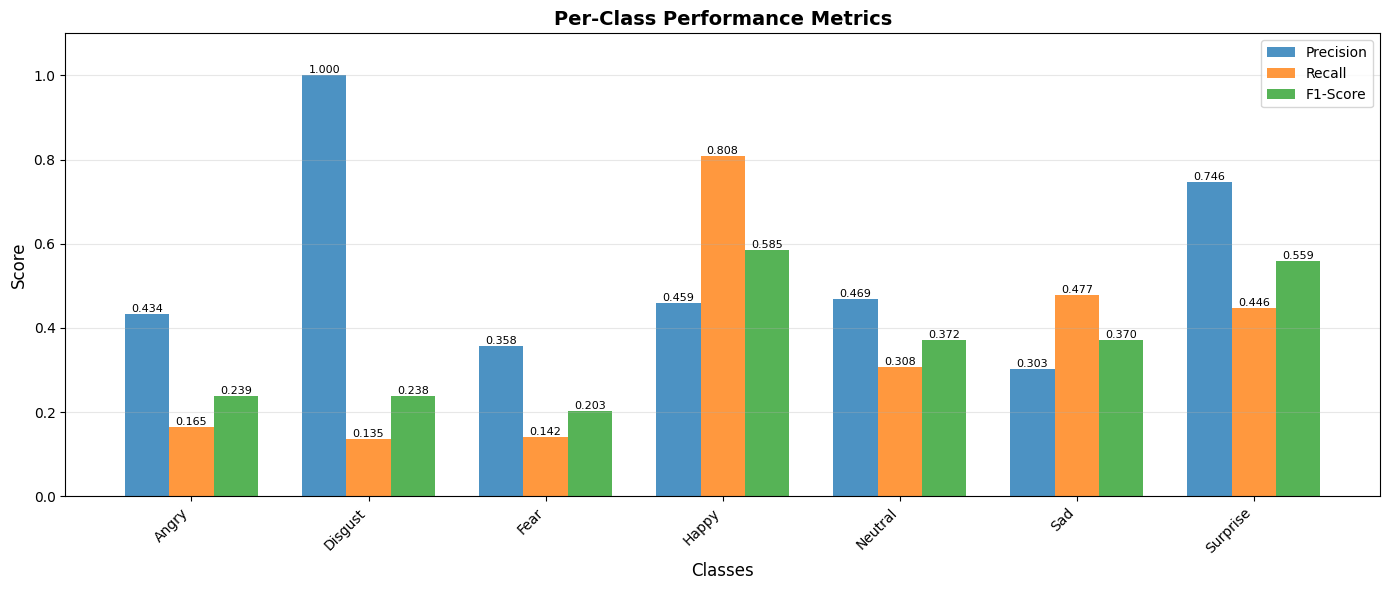

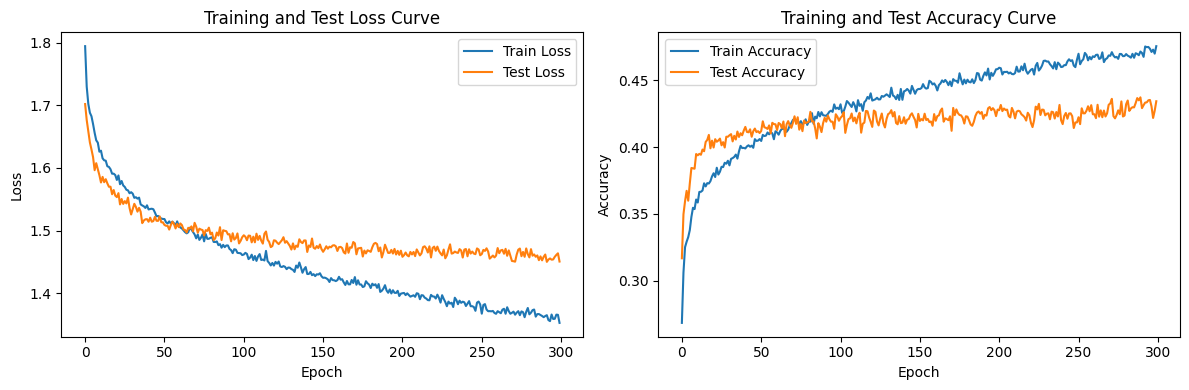


---Confusion Matrix---


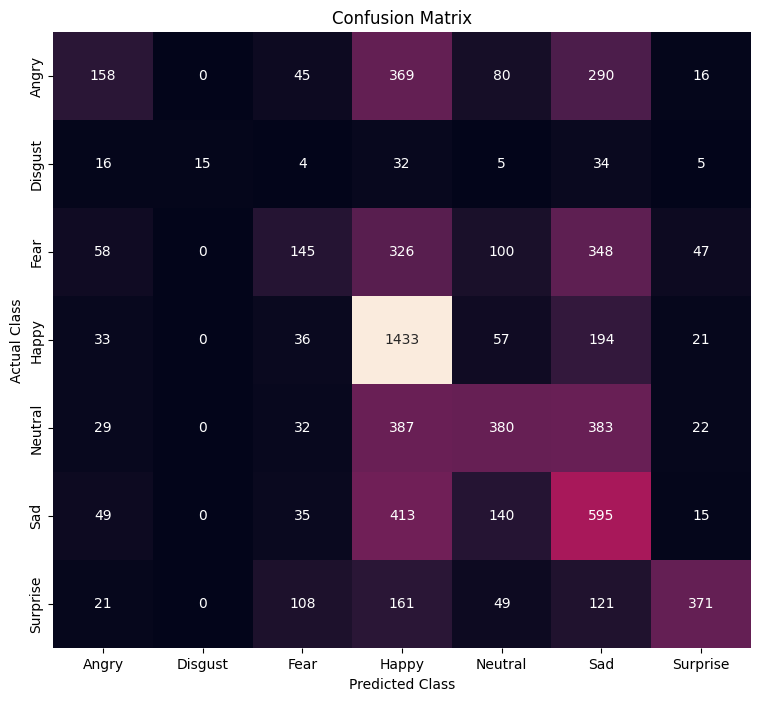

In [3]:
import torch
import torch.nn as nn
import json
import torch.optim as optim
from src import MLP_network, Training, Evaluate, DataPreprocessing
from torchvision.transforms import v2
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

history_path = os.path.join("..", "content", "saved_model", "history_mlp.json")
model_path = os.path.join("..", "content", "saved_model", "best_mlp.pth")

#to Load the saved training history
with open(history_path, "r") as f:
    history_mlp = json.load(f)

device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")
list_of_transform_pipeline=[ v2.ToImage(),v2.Grayscale(num_output_channels=1),v2.ToDtype(torch.float32, scale=True), v2.Normalize(mean=mean,std=std)]
test_transformation = process.augment_and_transform_data(list_of_transform_pipeline=list_of_transform_pipeline,plot_original_vs_augmented=0)
test_dataset=ImageFolder(TEST_DATASET_ROOT,transform=test_transformation)
test_loader=DataLoader(test_dataset,batch_size=512,shuffle=False)

best_model=MLP_network().to(device)
best_model.load_state_dict(torch.load(model_path, map_location=device))
evaluate = Evaluate(best_model, device)
evaluate.print_classification_report(test_loader, class_names=["Angry","Disgust","Fear","Happy","Neutral","Sad","Surprise"])
evaluate.plot_per_class_metrics(test_loader, class_names=["Angry","Disgust","Fear","Happy","Neutral","Sad","Surprise"])
evaluate.plot_history(history_mlp)
evaluate.plot_confusion_matrix(test_loader)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from src.data.cnn import CNN_network
from src.data.Training import Training
from src.data.Evaluate import Evaluate
from torchvision.transforms import v2
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

list_of_transform_pipeline=[ v2.ToImage(),v2.Grayscale(num_output_channels=1),v2.ToDtype(torch.float32, scale=True), v2.Normalize(mean=mean,std=std)]
train_transformation = process.augment_and_transform_data(plot_original_vs_augmented=0)
test_transformation = process.augment_and_transform_data(list_of_transform_pipeline=list_of_transform_pipeline,plot_original_vs_augmented=0)
train_dataset=ImageFolder(TRAIN_DATASET_ROOT,transform=train_transformation)
train_loader=DataLoader(train_dataset,batch_size=512,shuffle=True)

test_dataset=ImageFolder(TEST_DATASET_ROOT,transform=test_transformation)
test_loader=DataLoader(test_dataset,batch_size=512,shuffle=False)

device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")
model_cnn=CNN_network().to(device)
SAVE_PATH='/content/saved_model/best_cnn.pth'
optimizer=optimizer=optim.Adam(model_cnn.parameters(),lr=1e-03)
loss_func=nn.CrossEntropyLoss()

trainer=Training(model=model_cnn,optimizer=optimizer,loss_func=loss_func,device=device,save_path=SAVE_PATH)
history_cnn=trainer.train_model(train_loader,test_loader,70)

Using cuda device
---Training----
Epoch 1 --- train_loss 1.757761485458122, train_acc 0.2736424117872444 --- test_loss 1.658153617372085, test_acc 0.3439676790192254
---Training----
Epoch 2 --- train_loss 1.6205491479601064, train_acc 0.36438050785467974 --- test_loss 1.5253936263570949, test_acc 0.4102814154360546
---Training----
Epoch 3 --- train_loss 1.5223731472805386, train_acc 0.4151311435438364 --- test_loss 1.41924017187811, test_acc 0.4543048202842017
---Training----
Epoch 4 --- train_loss 1.4528011605634041, train_acc 0.4423003239402278 --- test_loss 1.3742931806532976, test_acc 0.47826692672053495
---Training----
Epoch 5 --- train_loss 1.3950353179415955, train_acc 0.46633459890626633 --- test_loss 1.3199288277248713, test_acc 0.4882975759264419
---Training----
Epoch 6 --- train_loss 1.3568758720007763, train_acc 0.4796753631265457 --- test_loss 1.3013972133173854, test_acc 0.5009752020061299
---Training----
Epoch 7 --- train_loss 1.3220139511318607, train_acc 0.498136472883

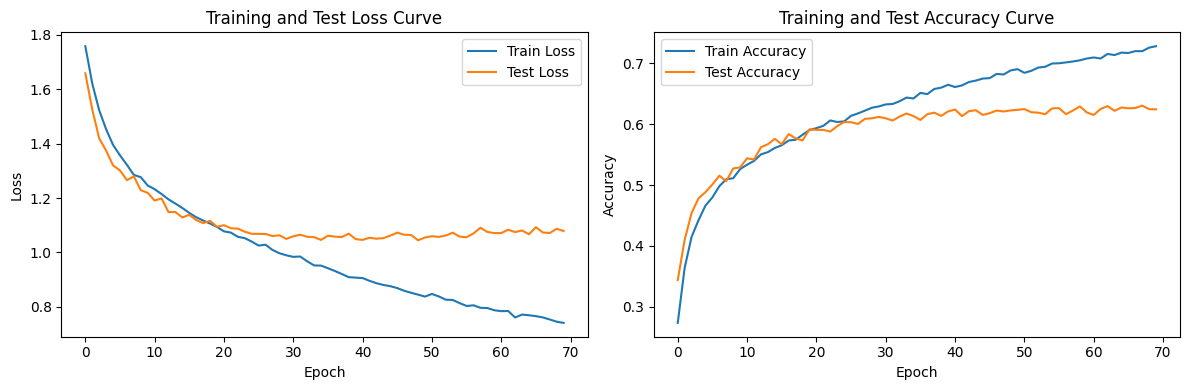


---Confusion Matrix---


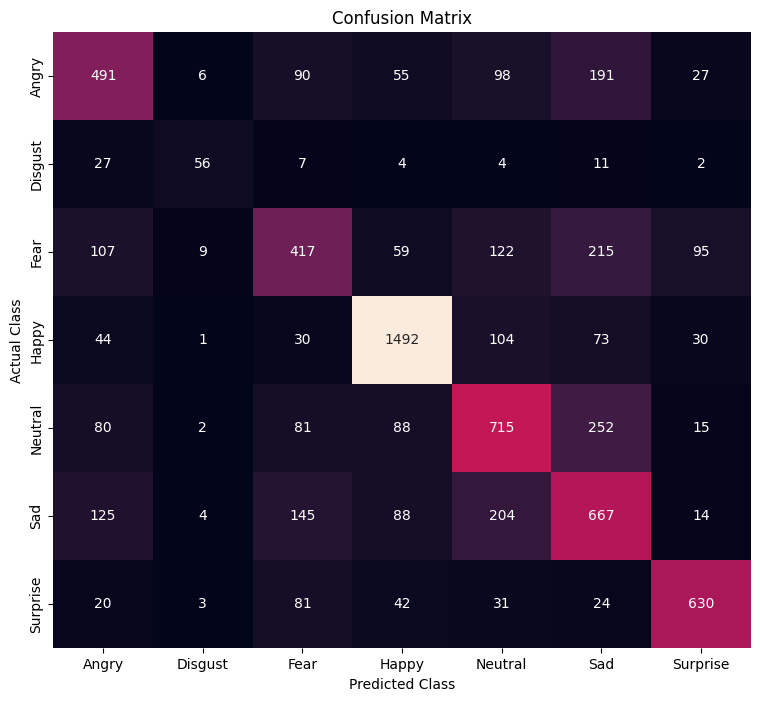

In [ ]:
best_model=CNN_network().to(device)
best_model.load_state_dict(torch.load('/content/saved_model/best_cnn.pth', map_location=device))
evaluate = Evaluate(best_model, device)
evaluate.plot_history(history_cnn)
evaluate.plot_confusion_matrix(test_loader)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
import src.data.rasnet18
importlib.reload(src.data.rasnet18)
from src.data.rasnet18 import Rasnet18
from src.data.Training import Training
from src.data.Evaluate import Evaluate
from torchvision.transforms import v2
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

list_of_transform_pipeline=[ v2.ToImage(),v2.Grayscale(num_output_channels=1),v2.ToDtype(torch.float32, scale=True), v2.Normalize(mean=mean,std=std)]
train_transformation = process.augment_and_transform_data(plot_original_vs_augmented=0)
test_transformation = process.augment_and_transform_data(list_of_transform_pipeline=list_of_transform_pipeline,plot_original_vs_augmented=0)
train_dataset=ImageFolder(TRAIN_DATASET_ROOT,transform=train_transformation)
train_loader=DataLoader(train_dataset,batch_size=512,shuffle=True)

test_dataset=ImageFolder(TEST_DATASET_ROOT,transform=test_transformation)
test_loader=DataLoader(test_dataset,batch_size=512,shuffle=False)

device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")
rsnt=Rasnet18()
model_rasnet = rsnt.get_custom_rasnet(use_pretrained=1).to(device)
SAVE_PATH='/content/saved_model/best_rsnt.pth'
optimizer=optimizer=optim.Adam(model_rasnet.parameters(),lr=1e-03)
loss_func=nn.CrossEntropyLoss()

trainer=Training(model=model_rasnet,optimizer=optimizer,loss_func=loss_func,device=device,save_path=SAVE_PATH)
history_cnn=trainer.train_model(train_loader,test_loader,50)

Using cuda device
---Training----
Epoch 1 --- train_loss 1.7020167489963505, train_acc 0.3350517259396008 --- test_loss 1.5038267040226114, test_acc 0.41836166062970187
---Training----
Epoch 2 --- train_loss 1.45774909750646, train_acc 0.4376676303598175 --- test_loss 1.483748807120569, test_acc 0.4378657007522987
---Training----
Epoch 3 --- train_loss 1.4025275332040184, train_acc 0.45915914869901425 --- test_loss 1.3276999042571571, test_acc 0.4880189467818334
---Training----
Epoch 4 --- train_loss 1.3049651343183268, train_acc 0.5040231286356195 --- test_loss 1.3279650446580757, test_acc 0.5084981889105601
---Training----
Epoch 5 --- train_loss 1.2202049663952224, train_acc 0.5381587655439061 --- test_loss 1.5170252248416474, test_acc 0.4765951518528838
---Training----
Epoch 6 --- train_loss 1.3416753683208469, train_acc 0.4876171235501062 --- test_loss 1.2432285135056056, test_acc 0.5243800501532461
---Training----
Epoch 7 --- train_loss 1.217451395163479, train_acc 0.5370093002194

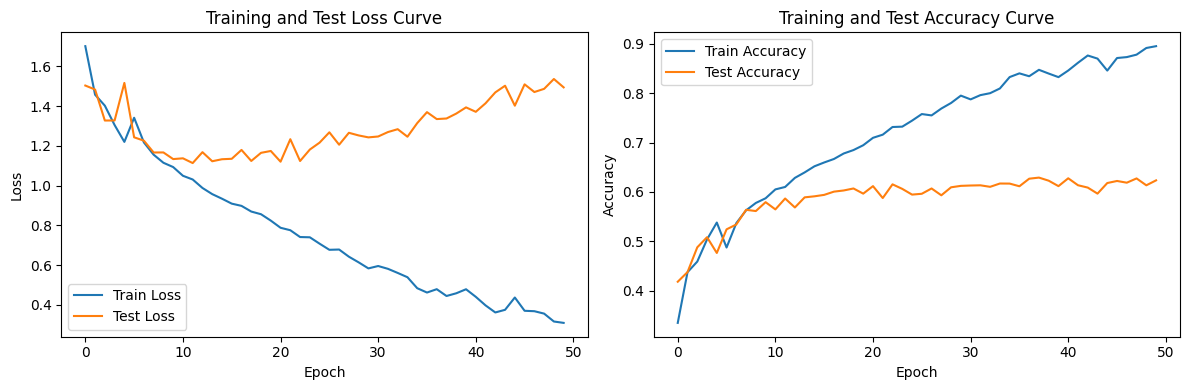


---Confusion Matrix---


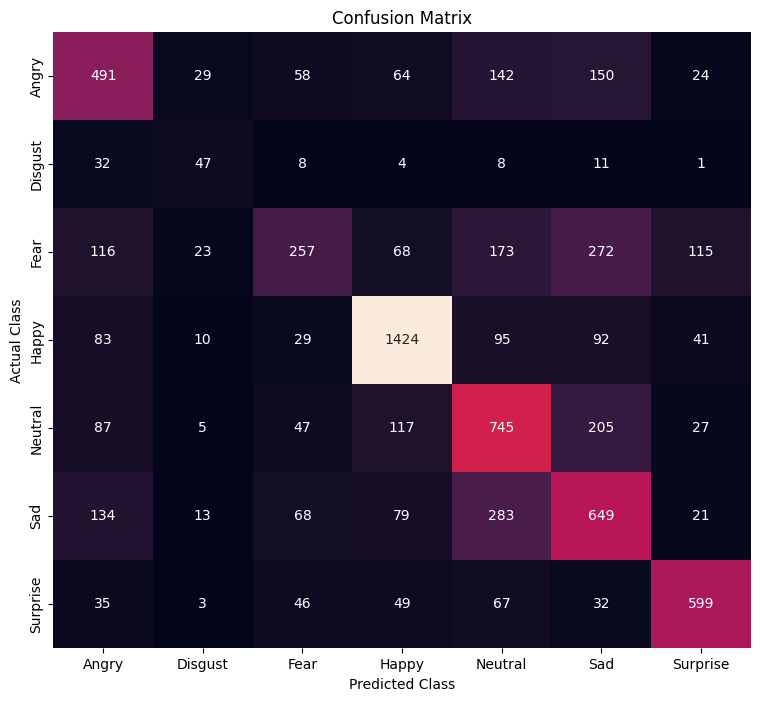

In [ ]:
best_model=rsnt.get_custom_rasnet().to(device)
best_model.load_state_dict(torch.load('/content/saved_model/best_rsnt.pth', map_location=device))
evaluate = Evaluate(best_model, device)
evaluate.plot_history(history_cnn)
evaluate.plot_confusion_matrix(test_loader)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
import src.data.rasnet18
importlib.reload(src.data.rasnet18)
from src.data.rasnet18 import Rasnet18
from src.data.Training import Training
from src.data.Evaluate import Evaluate
from torchvision.transforms import v2
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

list_of_transform_pipeline=[ v2.ToImage(),v2.Grayscale(num_output_channels=1),v2.ToDtype(torch.float32, scale=True), v2.Normalize(mean=mean,std=std)]
train_transformation = process.augment_and_transform_data(plot_original_vs_augmented=0)
test_transformation = process.augment_and_transform_data(list_of_transform_pipeline=list_of_transform_pipeline,plot_original_vs_augmented=0)
train_dataset=ImageFolder(TRAIN_DATASET_ROOT,transform=train_transformation)
train_loader=DataLoader(train_dataset,batch_size=512,shuffle=True)

test_dataset=ImageFolder(TEST_DATASET_ROOT,transform=test_transformation)
test_loader=DataLoader(test_dataset,batch_size=512,shuffle=False)

device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")
rsnt=Rasnet18()
model_rasnet = rsnt.get_custom_rasnet(use_pretrained=0).to(device)
SAVE_PATH='/content/saved_model/best_rsnt1.pth'
optimizer=optimizer=optim.Adam(model_rasnet.parameters(),lr=1e-03)
loss_func=nn.CrossEntropyLoss()

trainer=Training(model=model_rasnet,optimizer=optimizer,loss_func=loss_func,device=device,save_path=SAVE_PATH)
history_cnn=trainer.train_model(train_loader,test_loader,50)

Using cuda device
---Training----
Epoch 1 --- train_loss 1.634016737419218, train_acc 0.3570657285171897 --- test_loss 1.4953665065712236, test_acc 0.4246308163833937
---Training----
Epoch 2 --- train_loss 1.4315127480087777, train_acc 0.44543522937058067 --- test_loss 1.3757630637775526, test_acc 0.46753970465310674
---Training----
Epoch 3 --- train_loss 1.335419550639276, train_acc 0.4867463164861193 --- test_loss 1.3464899710806408, test_acc 0.49080523822791866
---Training----
Epoch 4 --- train_loss 1.2818256564854356, train_acc 0.5086558222160298 --- test_loss 1.2385441511578799, test_acc 0.5218723878517693
---Training----
Epoch 5 --- train_loss 1.2229047673154414, train_acc 0.5325507680518304 --- test_loss 1.2603078227117555, test_acc 0.5157425466703818
---Training----
Epoch 6 --- train_loss 1.1781711647297846, train_acc 0.5493399282454979 --- test_loss 1.2262326330818416, test_acc 0.5249373084424631
---Training----
Epoch 7 --- train_loss 1.1374324072640145, train_acc 0.5719112473

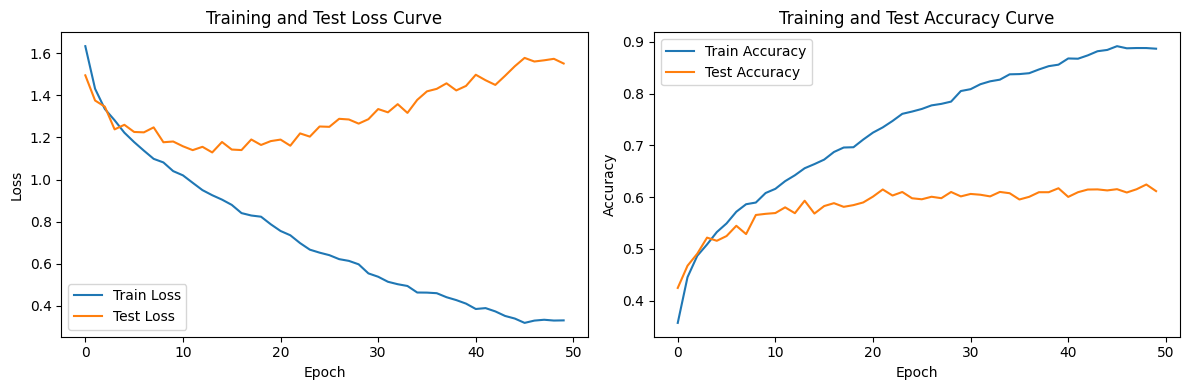


---Confusion Matrix---


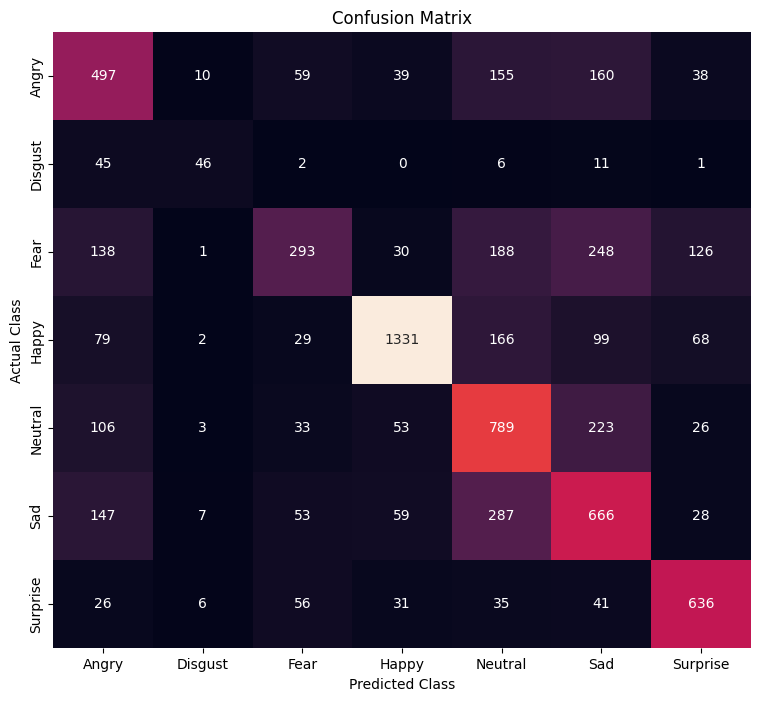

In [ ]:
best_model=rsnt.get_custom_rasnet().to(device)
best_model.load_state_dict(torch.load('/content/saved_model/best_rsnt1.pth', map_location=device))
evaluate = Evaluate(best_model, device)
evaluate.plot_history(history_cnn)
evaluate.plot_confusion_matrix(test_loader)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from src.data.cnn import CNN_network
from src.data.Training import Training
from src.data.Evaluate import Evaluate
from torchvision.transforms import v2
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader,WeightedRandomSampler
import numpy as np

list_of_transform_pipeline=[ v2.ToImage(),v2.Grayscale(num_output_channels=1),v2.ToDtype(torch.float32, scale=True), v2.Normalize(mean=mean,std=std)]
train_transformation = process.augment_and_transform_data(plot_original_vs_augmented=0)
test_transformation = process.augment_and_transform_data(list_of_transform_pipeline=list_of_transform_pipeline,plot_original_vs_augmented=0)

train_dataset=ImageFolder(TRAIN_DATASET_ROOT,transform=train_transformation)
test_dataset=ImageFolder(TEST_DATASET_ROOT,transform=test_transformation)

targets = np.array(train_dataset.targets)
class_counts = np.bincount(targets)
total_samples = len(targets)
loss_weights = torch.FloatTensor(total_samples / (7 * class_counts)).to(device)

train_loader=DataLoader(train_dataset,batch_size=512,shuffle=True)
test_loader=DataLoader(test_dataset,batch_size=512,shuffle=False)

device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")
model_cnn=CNN_network().to(device)
SAVE_PATH='/content/drive/MyDrive/saved_model/best_cnn_weighted_random_sampler.pth'
optimizer=optimizer=optim.Adam(model_cnn.parameters(),lr=1e-03)
loss_func=nn.CrossEntropyLoss(weight=loss_weights)

trainer=Training(model=model_cnn,optimizer=optimizer,loss_func=loss_func,device=device,save_path=SAVE_PATH)
history_cnn=trainer.train_model(train_loader,test_loader,100)

Using cuda device
---Training----
Epoch 1 --- train_loss 1.8930352020007888, train_acc 0.1980911909157407 --- test_loss 1.8018420768601213, test_acc 0.27932571747004736
---Training----
Epoch 2 --- train_loss 1.7462401272066417, train_acc 0.31704343585635164 --- test_loss 1.5799240404664723, test_acc 0.38576205071050435
---Training----
Epoch 3 --- train_loss 1.6193752613032415, train_acc 0.37761677522728065 --- test_loss 1.4764120593048398, test_acc 0.44357759821677345
---Training----
Epoch 4 --- train_loss 1.5417326410311119, train_acc 0.40666689888188373 --- test_loss 1.3983263557885277, test_acc 0.4736695458344943
---Training----
Epoch 5 --- train_loss 1.475123178444419, train_acc 0.43662266188303317 --- test_loss 1.3503851997433813, test_acc 0.4742268041237113
---Training----
Epoch 6 --- train_loss 1.4337617278269306, train_acc 0.44832630882301716 --- test_loss 1.323561389106135, test_acc 0.4917804402340485
---Training----
Epoch 7 --- train_loss 1.3994486368563261, train_acc 0.45950

In [ ]:
import json
json.dump(history_cnn,open("/content/drive/MyDrive/saved_model/history_cnn_with_handling_im_data.json", 'w'))

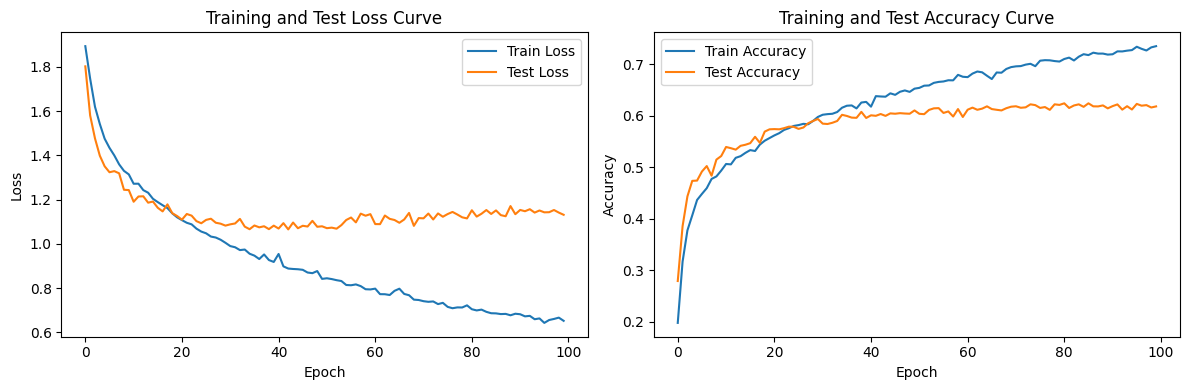


---Confusion Matrix---


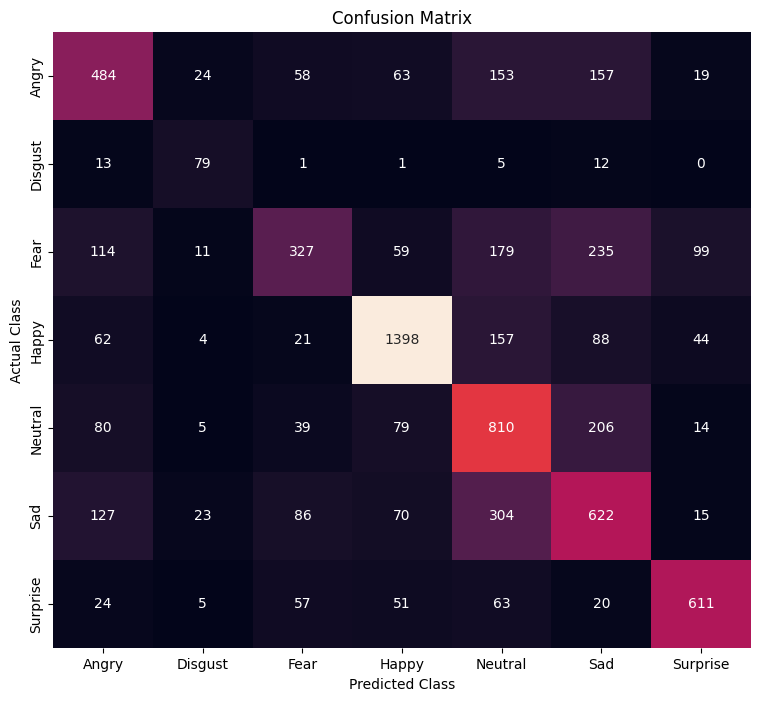

In [ ]:
best_model=CNN_network().to(device)
best_model.load_state_dict(torch.load('/content/drive/MyDrive/saved_model/best_cnn_weighted_random_sampler.pth', map_location=device))
evaluate = Evaluate(best_model, device)
evaluate.plot_history(history_cnn)
evaluate.plot_confusion_matrix(test_loader)